In [1]:
using LinearAlgebra, Statistics, Random, Plots, AllanDeviations

In [2]:
#Generate Synthetic Data from a 2nd order linear system (you can relax the assumptions I made and fit more parameters)
dt = 0.05
N = 100000
w = randn(2,N)
k = 0.1;
c = 1.0;
d = 0.1
q = 0.01;
r = 0.01;
Ac = [0 1; -k -c];
Bc = [0 0; q 0];
ABd = exp(dt*[Ac Bc; zeros(2,4)])
A = ABd[1:2,1:2]
B = ABd[1:2,3:4]
C = [1 d];
D = [0 r];
x = zeros(2,N)
y = zeros(N);
for k = 1:(N-1)
    x[:,k+1] = A*x[:,k] + B*w[:,k]
end
for k = 1:N
    y[k] = (C*x[:,k] + D*w[:,k])[1];
end

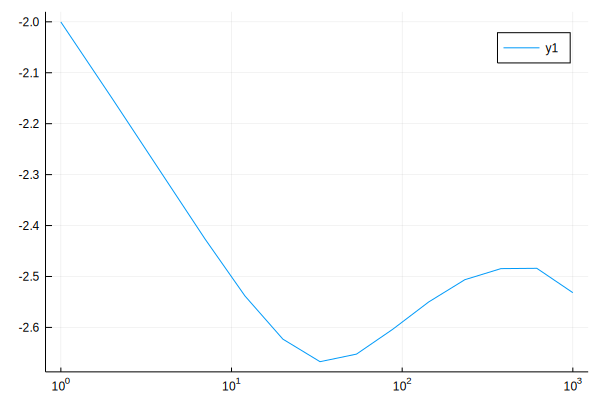

In [3]:
bins = 20
τ_max = floor(N/100) #Note I'm not going too high on this to avoid the noisy tail
τ = Int.(floor.(10.0.^range(log10(.1), log10(τ_max), length=bins)))
ay = allandev(y, 1.0, frequency=true, taus=Float64.(τ))
truth = log10.(ay[:deviation]);
plot(ay[:tau], truth, xaxis=:log)

In [4]:
#This returns the vector of errors that you're trying to drive to zero (rather than the least-squares objective)
#This is better numerically than trying to solve the least-squares problem directly
function logErrors(p)
    dt = 0.05
    N = 100000
    w = randn(2,N)
    k = p[1]
    c = p[2]
    d = p[3]
    q = p[4]
    r = p[5]
    Ac = [0 1; -k -c];
    Bc = [0 0; q 0];
    ABd = exp(dt*[Ac Bc; zeros(2,4)])
    A = ABd[1:2,1:2]
    B = ABd[1:2,3:4]
    C = [1 d];
    D = [0 r];
    x = zeros(2,N)
    y = zeros(N);
    for k = 1:(N-1)
        x[:,k+1] = A*x[:,k] + B*w[:,k]
    end
    for k = 1:N
        y[k] = (C*x[:,k] + D*w[:,k])[1];
    end
    bins = 20
    τ_max = floor(N/100)
    τ = Int.(floor.(10.0.^range(log10(.1), log10(τ_max), length=bins)))
    ay = allandev(y, 1.0, frequency=true, taus=Float64.(τ))
    return log10.(ay[:deviation]) - truth
end

logErrors (generic function with 1 method)

In [5]:
#Average several calls to the error function to smooth things out
function avgErrors(p)
    Ne = length(logErrors(p))
    Np = length(p)
    Nsamp = 10*Np
    E0 = zeros(Ne)
    for k = 1:Nsamp
        E0 = E0 + logErrors(p)/Nsamp
    end
    return E0
end

avgErrors (generic function with 1 method)

In [6]:
#This function computes a sample-based approximate Jacobian in the spirit of CMA
#Note this is pretty expensive, so we want to recycle it several times in our quasi-Newton method
function sampleJacobian(p)
    Ne = length(logErrors(p))
    Np = length(p)
    Nsamp = 10*Np
    D = zeros(Np,Nsamp)
    E = zeros(Ne,Nsamp)
    E0 = avgErrors(p)
    for k = 1:Nsamp
        D[:,k] = 0.01*randn(Np)
        E[:,k] = (logErrors(p+D[:,k]) - E0)
    end
    J = reshape(kron(D',Matrix(I,Ne,Ne))\vec(E),Ne,Np)
end

sampleJacobian (generic function with 1 method)

In [7]:
p = [0.1; 0.5; 0.2; 0.1; 0.1] #starting guess at parameter vector

5-element Array{Float64,1}:
 0.1
 0.5
 0.2
 0.1
 0.1

In [8]:
e = avgErrors(p) #initial error vector

14-element Array{Float64,1}:
 1.0003036520324637
 0.9998915302862762
 1.003281842900856 
 1.008519635873994 
 1.0186645534611851
 1.046471939928705 
 1.111107014258465 
 1.184461386082593 
 1.236237222318637 
 1.2489363686653174
 1.2122571683115144
 1.1402527697315374
 1.058396812954924 
 1.0135849611649639

In [56]:
J = sampleJacobian(p); #compute Jacobian 

In [61]:
p = p - 0.1*(J\e) #update p with a damped Newton step

5-element Array{Float64,1}:
 0.06466168110021103  
 0.7273311322797283   
 0.2860902873939201   
 0.0067842118089359305
 0.009152493261061628 

In [62]:
e = logErrors(p) #compute new error vector

14-element Array{Float64,1}:
 -0.03805068087858432  
 -0.040184659763198294 
 -0.037716338224532464 
 -0.03351734408840068  
 -0.027573978047939374 
 -0.030899753062015645 
 -0.03736095179160115  
 -0.030511780528229338 
 -0.021543465149193253 
 -0.010668739852530251 
  0.0029086586248743274
  0.016977853738213255 
  0.017644575459532685 
  0.02040559398268993  

In [ ]:
#Looking at statistics of Allan Variance to see how bad the variance is between function calls
Nsamp = 1000
E = zeros(14,Nsamp)
E0 = zeros(14)
for k = 1:Nsamp
    E[:,k] = logErrors(p)
    E0 = E0 + E[:,k]/Nsamp
end
S = zeros(14,14)
for k = 1:Nsamp
    S = S + (1/Nsamp)*(E[:,k]-E0)*(E[:,k]-E0)'
end

In [ ]:
#Compute Allan Variance myself to sanity check things
bins = 20
τ_max = floor(N/10)
τ = Int.(floor.(10.0.^range(log10(2.5), log10(τ_max), length=bins)))
av = zeros(bins);
for j = 1:bins
    Nr = N-τ[j]+1
    r = zeros(Nr) #running avg.
    r[1] = sum(y[1:τ[j]])/τ[j]
    for k = 2:Nr
        r[k] = r[k-1] + (y[(k-1)+τ[j]] - y[k-1])/τ[j]
    end
    av[j] = sqrt(cov(r))
end
plot(τ,av,xaxis=:log,yaxis=:log)